# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 50000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Submean()
      RandomHorizontalFlip(p=0.5)
) 256
test.transforms = Compose(
      ToTensor()
      Submean()
) 256


## Confirm that the dataset is loaded properly

In [6]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-2.9229e-09, -1.0162e-09, -3.3638e-09])
Shape of y: torch.Size([256]) torch.int64


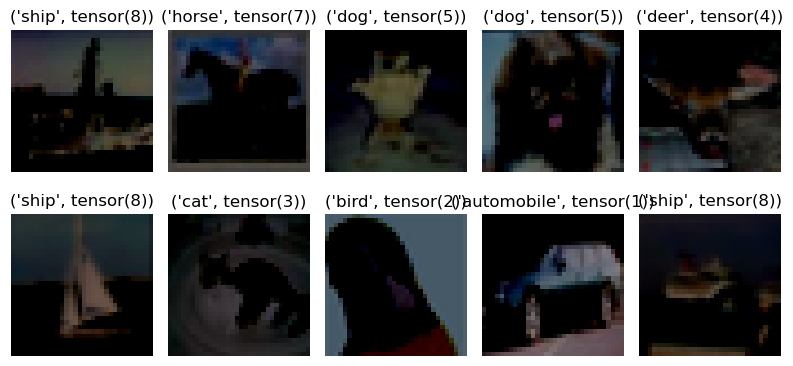

In [7]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [10]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
class EarlyStopper:
    def __init__(self, patience, model, file_path):
        self.best_eval_loss = float("inf")
        self.early_stop_counter = 0
        self.PATIENCE = patience
        self.file_path = file_path
        self.model = model
        pass

    def check(self, eval_loss):
        if eval_loss < self.best_eval_loss:
            self.best_eval_loss = eval_loss
            self.early_stop_counter = 0
            print("updated best eval loss :", self.best_eval_loss)
            torch.save(self.model.state_dict(), "models/" + self.file_path + ".pth")
            return False
        else:
            self.early_stop_counter += 1
            if self.early_stop_counter >= self.PATIENCE:
                print(f"Early stop!! best_eval_loss = {self.best_eval_loss}")
                return True
                
    def state_dict(self):
        return {"best_eval_loss": self.best_eval_loss, "early_stop_counter": self.early_stop_counter}
    
    def load_state_dict(self, state_dict):
        self.best_eval_loss = state_dict["best_eval_loss"]
        self.early_stop_counter = state_dict["early_stop_counter"]
        
        return
    
earlystopper = EarlyStopper(EARLYSTOPPINGPATIENCE, model, file_path)

## (4) Define Learning Rate schedualer

In [14]:
scheduler_mapping = {"CIFAR10": 1000, "CIFAR100": 1000, "ImageNet2012": 30}

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
)

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_SGD
Current epoch is 7462
Current learning rate: 0.0010000000000000005


In [17]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))

In [18]:
# scheduler.patience 수정하는 곳.

# optimizer.param_groups[0]["lr"]
scheduler.patience

500

In [19]:
optimizer.param_groups[0]["lr"]

0.0010000000000000005

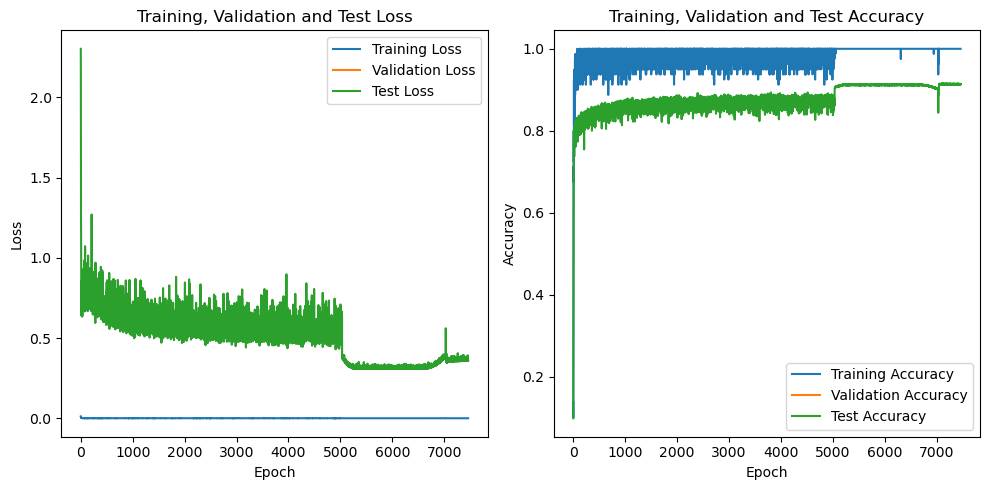

In [20]:
viewer = LogViewer(logs)
viewer.draw()

# [Training Loop]

In [21]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 7463/50000] :


100%|██████████| 196/196 [00:04<00:00, 46.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3645 | Test Acc: 91.47%
--------------------------------------------------
[Epoch 7464/50000] :


100%|██████████| 196/196 [00:03<00:00, 51.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3601 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7465/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.4007 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7466/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.67it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3727 | Test Acc: 91.27%
--------------------------------------------------
[Epoch 7467/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.50it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3603 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7468/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3627 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7469/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.35it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3704 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7470/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.81it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3619 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7471/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3692 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7472/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3692 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7473/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.81it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3699 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7474/50000] :


100%|██████████| 196/196 [00:03<00:00, 51.10it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3614 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7475/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.49it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3603 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7476/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.80it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3814 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7477/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.58it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3747 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7478/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.63it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3595 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7479/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.87it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3685 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7480/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.76it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3629 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 7481/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.74it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3720 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7482/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3899 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7483/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.80it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3712 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7484/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3770 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7485/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3630 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7486/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3623 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7487/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.33it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3726 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7488/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3664 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7489/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3608 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7490/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.66it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3637 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7491/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.52it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3638 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7492/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3700 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7493/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.63it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3666 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7494/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.73it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3612 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7495/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.75it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3613 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7496/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3674 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7497/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3644 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7498/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3893 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 7499/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.89it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3616 | Test Acc: 91.22%
--------------------------------------------------
[Epoch 7500/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.62it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3692 | Test Acc: 91.26%
--------------------------------------------------
[Epoch 7501/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.36it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3699 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7502/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3765 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7503/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.53it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3888 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7504/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.65it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3699 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7505/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.48it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3594 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7506/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3783 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7507/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.17it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3659 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7508/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.29it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3783 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 7509/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.21it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3745 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7510/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3741 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7511/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3762 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 7512/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3609 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7513/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.96it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3645 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7514/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3647 | Test Acc: 91.29%
--------------------------------------------------
[Epoch 7515/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.26it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.3791 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7516/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3877 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 7517/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3686 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 7518/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3637 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7519/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.11it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3712 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7520/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3927 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7521/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.69it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3697 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7522/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3609 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7523/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.71it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3830 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7524/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.19it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3647 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7525/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.89it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3713 | Test Acc: 91.29%
--------------------------------------------------
[Epoch 7526/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.15it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3624 | Test Acc: 91.27%
--------------------------------------------------
[Epoch 7527/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.94it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3795 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7528/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3622 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7529/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.20it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3629 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7530/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3660 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7531/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.25it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3622 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7532/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.01it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3607 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7533/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.52it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3652 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7534/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.50it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3633 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7535/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3798 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7536/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.70it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3678 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7537/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.48it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3689 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 7538/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.35it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3598 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7539/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.29it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3637 | Test Acc: 91.52%
--------------------------------------------------
[Epoch 7540/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3613 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7541/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3771 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7542/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3640 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7543/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.84it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3741 | Test Acc: 91.26%
--------------------------------------------------
[Epoch 7544/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3691 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7545/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3659 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7546/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.35it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3806 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7547/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3661 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 7548/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3635 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 7549/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3821 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7550/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.26it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3640 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7551/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.74it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3688 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7552/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3622 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7553/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3668 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7554/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3661 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7555/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.73it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3621 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7556/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.94it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3720 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7557/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3775 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 7558/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3761 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7559/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.47it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3707 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7560/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3935 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7561/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.50it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3801 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 7562/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.33it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3739 | Test Acc: 91.23%
--------------------------------------------------
[Epoch 7563/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3628 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7564/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.29it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3738 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7565/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.25it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3741 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7566/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.27it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3694 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7567/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.00it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3827 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7568/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.10it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3764 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7569/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.23it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3646 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7570/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3618 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7571/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3770 | Test Acc: 91.38%
Epoch 02456: reducing learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
[Epoch 7572/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.48it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3719 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7573/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.70it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3819 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7574/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.00it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3666 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7575/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3667 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7576/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.11it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3660 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7577/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3745 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 7578/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3629 | Test Acc: 91.46%
--------------------------------------------------
[Epoch 7579/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.21it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3710 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7580/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.18it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3770 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7581/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.82it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3630 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7582/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.31it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3825 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7583/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3691 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7584/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.96it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3730 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7585/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.14it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3742 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7586/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3857 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7587/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3643 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7588/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.42it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3639 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7589/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3713 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7590/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.69it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3638 | Test Acc: 91.42%
--------------------------------------------------
[Epoch 7591/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3678 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7592/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.34it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3707 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7593/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3627 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7594/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.20it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3762 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 7595/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3644 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7596/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3700 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7597/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3680 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7598/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3641 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7599/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.55it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3726 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7600/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.15it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3614 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7601/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.63it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.4047 | Test Acc: 91.42%
--------------------------------------------------
[Epoch 7602/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3776 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7603/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3772 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7604/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.19it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3633 | Test Acc: 91.42%
--------------------------------------------------
[Epoch 7605/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.27it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3787 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7606/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.26it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3737 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7607/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3707 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7608/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3789 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7609/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.36it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3808 | Test Acc: 91.42%
--------------------------------------------------
[Epoch 7610/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.34it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3761 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7611/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.76it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3625 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7612/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3620 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7613/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.44it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3664 | Test Acc: 91.29%
--------------------------------------------------
[Epoch 7614/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.26it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3987 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7615/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3776 | Test Acc: 91.29%
--------------------------------------------------
[Epoch 7616/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.30it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3617 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7617/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3710 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7618/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.92it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3749 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7619/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.19it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3666 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7620/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.03it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3688 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7621/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3703 | Test Acc: 91.24%
--------------------------------------------------
[Epoch 7622/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.89it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3681 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7623/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.89it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3645 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7624/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.44it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3638 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 7625/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.27it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3827 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7626/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3632 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7627/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.33it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3632 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7628/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.49it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3808 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7629/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.48it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3643 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7630/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.50it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3814 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7631/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.67it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3923 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 7632/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3814 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7633/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3661 | Test Acc: 91.27%
--------------------------------------------------
[Epoch 7634/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.81it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3754 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7635/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.36it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3624 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7636/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3853 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7637/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3819 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 7638/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.47it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3700 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 7639/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3663 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7640/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3653 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7641/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.48it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3643 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7642/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3814 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 7643/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3661 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 7644/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.53it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3909 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7645/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.23it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3633 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7646/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3684 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7647/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.42it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3662 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7648/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3620 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 7649/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.65it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3717 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 7650/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3638 | Test Acc: 91.29%
--------------------------------------------------
[Epoch 7651/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3834 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7652/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3795 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7653/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3820 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7654/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3644 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7655/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3828 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7656/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3841 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7657/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.73it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3621 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7658/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.23it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3889 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7659/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3642 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 7660/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3671 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7661/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.50it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3758 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7662/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3837 | Test Acc: 91.42%
--------------------------------------------------
[Epoch 7663/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3727 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 7664/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3655 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7665/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.54it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3622 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7666/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.42it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3636 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7667/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3613 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7668/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3857 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7669/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.26it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3742 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7670/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3651 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 7671/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.30it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3638 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7672/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3688 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7673/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.86it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3673 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7674/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.75it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3652 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7675/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.48it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3733 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7676/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3956 | Test Acc: 91.34%
--------------------------------------------------
[Epoch 7677/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3652 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 7678/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3685 | Test Acc: 91.27%
--------------------------------------------------
[Epoch 7679/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.83it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3731 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7680/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3755 | Test Acc: 91.47%
--------------------------------------------------
[Epoch 7681/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3806 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7682/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3664 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7683/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.49it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3755 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7684/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.96it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3627 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 7685/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.18it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3794 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7686/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3838 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 7687/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.12it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3709 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 7688/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.27it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3644 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7689/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3833 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7690/50000] :


100%|██████████| 196/196 [00:03<00:00, 49.82it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3785 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7691/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.42it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3727 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 7692/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.25it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3635 | Test Acc: 91.35%
--------------------------------------------------
[Epoch 7693/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.08it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3786 | Test Acc: 91.33%
--------------------------------------------------
[Epoch 7694/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.69it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3719 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7695/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.49it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3687 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 7696/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.63it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.4018 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7697/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3645 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 7698/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.35it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3631 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 7699/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3828 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 7700/50000] :


100%|██████████| 196/196 [00:03<00:00, 50.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3631 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 7701/50000] :


  0%|          | 0/196 [00:00<?, ?it/s]

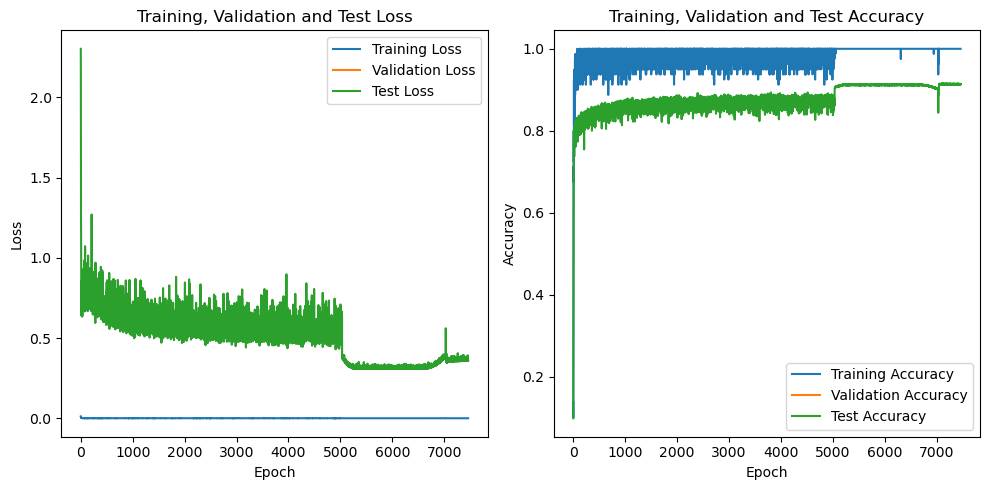

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

1 epoch: train_loss=0.0118, train_acc=0.1375, test_loss=2.3033, test_acc=0.0987, lr=0.1000
2 epoch: train_loss=0.0112, train_acc=0.1000, test_loss=2.2203, test_acc=0.1732, lr=0.1000
3 epoch: train_loss=0.0089, train_acc=0.3750, test_loss=1.7736, test_acc=0.3604, lr=0.1000
4 epoch: train_loss=0.0062, train_acc=0.5500, test_loss=1.6408, test_acc=0.4267, lr=0.1000
5 epoch: train_loss=0.0053, train_acc=0.5875, test_loss=1.3253, test_acc=0.5186, lr=0.1000
6 epoch: train_loss=0.0048, train_acc=0.7125, test_loss=1.2669, test_acc=0.5648, lr=0.1000
7 epoch: train_loss=0.0047, train_acc=0.6750, test_loss=1.1324, test_acc=0.6224, lr=0.1000
8 epoch: train_loss=0.0032, train_acc=0.8000, test_loss=1.0242, test_acc=0.6489, lr=0.1000
9 epoch: train_loss=0.0034, train_acc=0.7875, test_loss=0.8742, test_acc=0.7036, lr=0.1000
10 epoch: train_loss=0.0026, train_acc=0.8000, test_loss=0.9760, test_acc=0.6811, lr=0.1000
11 epoch: train_loss=0.0029, train_acc=0.7875, test_loss=0.7942, test_acc=0.7365, lr=0.10